In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import zscore

In [2]:
%matplotlib inline

In [3]:
sns.set_style('whitegrid')

In [4]:
TAD_FILE = "../DATA/tads_new.csv"
res = 5000

In [5]:
df_tad = pd.DataFrame.from_csv(TAD_FILE, sep=',', header=0, index_col=None)

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [6]:
df_tad.loc[:,"bgn"] = df_tad.start #//res
df_tad.loc[:,"end"] = df_tad.end-res #//res
df_tad.loc[:,"ch"] = df_tad.seqnames #.apply(lambda x: x[3:])

In [7]:
chrms = np.unique(df_tad.ch)
df_tad['length'] = df_tad.end-df_tad.bgn

In [8]:
filenames_full = '''BEAF_32.E0_14.narrowPeak.bedgraph  CTCF.E0_16.narrowPeak.bedgraph  M1BP.E0_24.narrowPeak.bedgraph'''.split()

filenames = ['_'.join(x.split('_')[0:-1]) for x in filenames_full]

In [9]:
filenames

['BEAF_32.E0', 'CTCF.E0', 'M1BP.E0']

In [10]:
df_log = pd.DataFrame({x:[] for x in ['ch', 'bgn', 'end', 'val']})
for mode, full_mode in zip(filenames, filenames_full):
    DATA_FILE = "../DATA/PROFILES/{}".format(full_mode)
    df_tmp = pd.read_csv(DATA_FILE, sep='\s', header=None, index_col=None, skiprows=0)
    df_tmp.columns = ['ch', 'bgn', 'end', 'val']
    df_tmp['m'] = mode
    df_log = pd.concat([df_log, df_tmp])
    

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [11]:
### Filling interTADs
df_tad['annot'] = 't'
df_full = pd.DataFrame(columns=df_tad.columns)

for ch in chrms:
    cond = (df_tad.ch==ch)
    small_df = df_tad[cond]
    small_df = small_df.sort_values('bgn').reset_index(drop=True)
    small_df.bgn = small_df.bgn
    small_df.end = small_df.end

    s  = small_df.bgn.values
    s1 = small_df.end.values[:-1]
    s2 = s[1:]
    df_tmp = pd.DataFrame({'bgn':s1, 'end':s2})
    df_tmp['length'] = df_tmp.end-df_tmp.bgn
    df_tmp['annot'] = 'i'
    df_tmp = df_tmp[df_tmp.bgn!=df_tmp.end]
    df_tmp['ch'] = ch
    df_full = pd.concat([df_full, small_df, df_tmp])
    
df_full['mid'] = df_full.bgn+(df_full.end-df_full.bgn)/2

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [12]:
# Creating halfs of TADs (left and right)

df_new = df_full.copy(deep=True)
df_new.annot = 'l'+df_new.annot
df_new.end = df_new.mid

df_tmp = df_full.copy(deep=True)
df_tmp.annot = 'r'+df_tmp.annot
df_tmp.bgn = df_tmp.mid

df_new = pd.concat([df_new, df_tmp]).reset_index(drop=True)
df_new = df_new.drop('mid', axis=1)

df_new = df_new.sort_values(['ch', 'bgn']).reset_index(drop=True)

In [14]:
#df_full['mid'] = df_full.bgn+(df_full.end-df_full.bgn)/2

In [13]:
# for each data bin we assign left and right boundary of half-tads

for ch in chrms:
    print(ch)
    mask  = df_new.ch==ch
    mask1 = df_log.ch==ch
    idx = np.digitize(df_log[mask1].bgn, df_new[mask].bgn) 
    df_log.loc[mask1, 'struct'] = np.concatenate([[np.nan], df_new[mask].annot.values])[idx]
    df_log.loc[mask1, 'tad_bgn'] = np.concatenate([[np.nan], df_new[mask].bgn.values])[idx]
    df_log.loc[mask1, 'tad_end'] = np.concatenate([[np.nan], df_new[mask].end.values])[idx]

chr2L
chr2R
chr3L
chr3R
chrX


In [14]:
df_log['dist_to_start'] = df_log.bgn - df_log.tad_bgn
df_log['dist_to_end']   = df_log.tad_end - df_log.bgn 

In [16]:
df_log = df_log.replace([np.inf, -np.inf], np.nan)
df_log = df_log.dropna().reset_index(drop=True)

In [17]:
for mode in filenames:
    print(mode)
    mask = (df_log.m == mode)
    df_log.loc[mask, 'z_val'] = df_log.loc[mask,'val'] #zscore(df_log.loc[mask,'val'])

BEAF_32.E0
CTCF.E0
M1BP.E0


In [32]:
toplot_all = pd.DataFrame(columns=[u'std_z', u'z', 'bins', 'm'])

for mode in filenames:
    
    rng = [-1e5, 1e5, 5e3]

    mean_z, std_z, counts, all_bins = [np.empty(0), np.empty(0), np.empty(0), np.empty(0)]

    for struct in ['rt', 'lt', 'ri', 'li']:
        df_tmp = df_log[(df_log.m==mode)&(df_log.struct==struct)].reset_index(drop=True)
        bins = np.arange(0, rng[1], rng[2])
        if 'r' in struct:
            groups = df_tmp.groupby(np.digitize(df_tmp.dist_to_end, bins))
        else:
            groups = df_tmp.groupby(np.digitize(df_tmp.dist_to_start, bins))

        mean_z_tmp = groups.mean().z_val.values
        
        std_z_tmp  = groups.count().z_val.values

        if 'i' in struct:
            bins = -bins-rng[2] ### !!!

        mean_z = np.concatenate([mean_z, mean_z_tmp])
        std_z  = np.concatenate([std_z,  std_z_tmp])
        all_bins = np.concatenate([all_bins, np.concatenate([[np.nan], bins])[groups.mean().index]] )

    toplot = pd.DataFrame({'bins': all_bins, 'z': mean_z, 'std_z': std_z}).groupby('bins').mean()
    toplot['m'] = mode
    toplot['bins'] = toplot.index
    
    toplot_all = pd.concat([toplot_all, toplot]).reset_index(drop=True)

/home/agalicina/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [33]:
colors = ['#FCF128', 
          '#FCF128', 
          '#006CC3', 
          '#006CC3', 
          '#D05836', 
          '#89A4D4', 
          '#737F86', 
          '#006CC3', 
          '#D05836', 
          '#D05836',
          '#89A4D4', 
          '#737F86', 
          '#FCF128'
         ]

In [34]:
col_dict = {filenames[i]:colors[i] for i in range(len(filenames))}

In [45]:
from scipy.interpolate import interp1d

def plot_lines_multi(toplot, rng, filenames=None, colors=None, names=None):
    plt.figure(figsize=(8,5))
    plt.xlim(rng[0], rng[1])
    plt.title('InterTAD -> TAD')
    plt.xticks(np.arange(rng[0], rng[1], rng[2]))
    for i, mode in enumerate(filenames):
        mask = toplot.m==mode
        filtered = lowess(zscore(toplot.loc[mask,'z']), toplot.loc[mask,'bins'], is_sorted=False, frac=0.2, it=3)
        plt.plot( filtered[:,0], filtered[:,1], colors[i], label=names[i], linewidth=2)
    plt.legend()
    
def plot_lines_multi_calc_z(toplot_initial, rng, filenames=None, colors=None, names=None, smooth=True):
    toplot = toplot_initial.loc[np.in1d(toplot_initial.bins, np.arange(*rng)),:].copy()
    plt.figure(figsize=(10,7))
    plt.xlim(rng[0], rng[1])
    plt.title('InterTAD -> TAD')
    plt.xticks(np.arange(rng[0], rng[1], rng[2]))
    for i, mode in enumerate(filenames):
        mask = (toplot.m==mode)
        vals = toplot.loc[mask, 'z']
        if smooth:
            filtered = lowess(vals, toplot.loc[mask,'bins'], is_sorted=False, frac=0.3, it=6)

            f = interp1d(filtered[:,0], filtered[:,1], bounds_error=False, kind='cubic')
            xnew = np.arange(rng[0], rng[1], (rng[1]-rng[0])/1000)
            ynew = f(xnew)
            
            plt.plot( xnew, ynew, colors[i], label=names[i], linewidth=2)
            plt.scatter(toplot.loc[mask,'bins'], vals, s=80, 
                        marker='o', lw=1.3, facecolors='none', edgecolors=colors[i])
        else:
            sns.regplot(x=toplot.loc[mask,'bins'], y=zscore(toplot.loc[mask,'z']),
                        scatter_kws={"s": 40, "marker": "o"}, label=names[i], lowess=True, #order=5, # # 
                        color=colors[i], ci=None)
        plt.xticks(rotation=70)
    plt.legend()

In [41]:
filenames_tmp = filenames
names_tmp = filenames
colors_tmp = ['#82D3BD', '#00A679', '#BEB5DB']

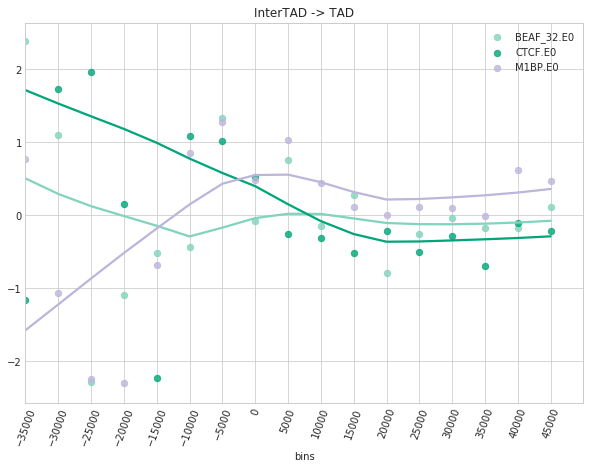

In [46]:
plot_lines_multi_calc_z(toplot_all, [-35000, 5e4, 5e3], 
                 filenames=filenames_tmp, 
                 colors=colors_tmp,
                names=names_tmp, 
                smooth=False)

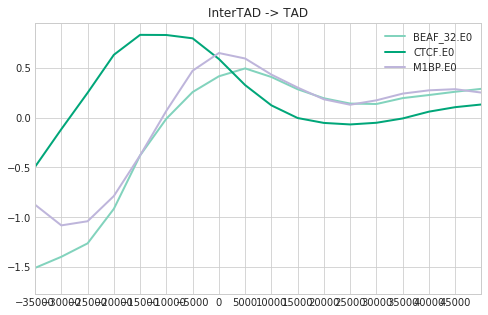

In [48]:
plot_lines_multi(toplot_all, [-35000, 5e4, 5e3], 
                 filenames=filenames_tmp, 
                 colors=colors_tmp,
                names=names_tmp)